# Gray code encoding for ab initio interaction

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [2]:
def generate_relative_states(Nmax,J,L=-1):
    """
    Generate deuteron basis for J subject to antisymmetry constraints
    """
    ## For deuteron, J=1
    i=0
    labels={}
    
    Nlist=list(range(0,Nmax+1,2))
 
    
    for T in [0,1]:
        for N in Nlist:
            ## If restricted to specific L channel
            if L==-1:
                L_values=list(range(N%2,N+1,2))
            else:
                L_values=[L]
                
            for L in L_values:
                for S in [0,1]:
                
                    if (N+S+T)%2!=1:
                        continue
                    if abs(L-S)<=J and (L+S)>=J:
                        labels[(N,L,S,J,T)]=i
                        i += 1

    return labels


def get_interaction(filename,basis):
    """
    Read in interaction from file. 
    File format is given in spncci/basis/lsjt_operator.h
    """
#     basis=generate_relative_states(Nmax,J)
    dim=len(basis)
    V=np.zeros((dim,dim))
    # interaction={}
    f=open(filename,'r')
    # Skipping header lines
    for i in range(6):
        next(f)
    ## Get relevant header information 
    operator_info=f.readline()
    operator_basis_info=f.readline()
    #for each line, get labels and matrix element, look up 
    for line in f:
        labels = tuple(map(int,line.split()[:11]))
        value = float(line.split()[11])
        [T0, Np, Lp, Sp, Jp, Tp, N, L, S, J, T]=labels
        statep = (Np, Lp, Sp, Jp, Tp)
        state = (N, L, S, J, T)
        if (statep in basis) and (state in basis):
            i = basis[state]
            ip = basis[statep]
            ## Sums over T0 values if relevant 
            V[ip,i] += value
            if ip!=i:
                V[i,ip] += value

    f.close()
#     print(V)
    return V

def toy_interaction(basis):
    """
    Read in interaction from file. 
    File format is given in spncci/basis/lsjt_operator.h
    """
#     basis=generate_relative_states(Nmax,J)
    dim=len(basis)
    V=np.zeros((dim,dim))
    # Skipping header lines

    for statep in basis:
        [Np,Lp,Sp,Jp,Tp]=statep
        ip=basis[statep]
        for state in basis:
            [N,L,S,J,T]=state
            i=basis[state]
            n=(N-L)/2
            n_prime=(Np-Lp)/2
            if(n==n_prime) and (n==0) and ((L,S,J,T)==(Lp,Sp,Jp,Tp)):
                V[ip,i] = -5.68658111

    return V


def Tme(Np,Lp,Sp,Jp,Tp,N,L,S,J,T,hw):
    """
    Compute kinetic energy matrix element for given hw values
    based on formula given in prc-93-2016-044332-Binder
    """
    # Kinetic energy
    if (Sp!=S) or (Tp!=T) or (Jp!=J) or (Lp!=L):
        return 0

    n=int((N-L)/2);
    tme=0.0
    if Np==N:
        tme = hw/2*(2*n+L+1.5)
    if Np==(N-2):
        tme = -hw/2*np.sqrt(n*(n+L+0.5))
    if Np==(N+2):
        tme=-hw/2*np.sqrt((n+1)*(n+L+1.5))

    return tme

def get_kinetic_energy(basis,hw):
    #Construct kinetic eneryg matrix
    dim=len(basis) 
    T_matrix=np.zeros((dim,dim))
    for statep in basis:
        [Np,Lp,Sp,Jp,Tp]=statep
        ip=basis[statep]
        for state in basis:
            [N,L,S,J,T]=state
            i=basis[state]

            T_matrix[ip,i]=Tme(Np,Lp,Sp,Jp,Tp,N,L,S,J,T,hw)
    return T_matrix


def hamiltonian_matrix(Nmax,hw,J,interaction_filename):
    
    if interaction_filename=="toy_hamiltonian":
        basis=generate_relative_states(Nmax,J,L=0)
        V_matrix=toy_interaction(basis)
        hw=7
    else:
        basis=generate_relative_states(Nmax,J)
        V_matrix=get_interaction(interaction_filename,basis)
    
    #Construct kinetic eneryg matrix 
    T_matrix=get_kinetic_energy(basis,hw)
    
    return T_matrix+V_matrix



def graycode_operator(s1,s2):
    """
    Generates graycode operators for moving from state s1 to states s2
    """
    # Sum the strings elementwise modulo 2; summed entries which are 1 must be flipped 
    string_sum = [(int(s1[i]) + int(s2[i])) % 2 for i in range(len(s1))]
    N_qubits=len(s1)
    qubit_term=[None]*N_qubits
    for b in range(N_qubits):        
        # bit is flipped 
        if string_sum[b]==1:
            if s1[b] == '0':
                # qubit_term[b]=["X","miY"]
                qubit_term[b]="A0"
            elif s1[b] == '1':
                # qubit_term[b]=["X","iY"]
                qubit_term[b]="A1"
            else:
                print("error")
        
        ## bit is same 
        else:
            x=s1[b]
            qubit_term[b] = f"P{x}"

    expanded_sequence=expand_projector_sequence(qubit_term)

    return expanded_sequence

def expand_projector_sequence(seq):
    # Take a list of projectors, e.g. ["P0", "P1", "X"] and expand it in terms of Paulis 
    # return an openfermion QubitOperator

    # Copy the sequence before making replacements
    substitution_seq = seq

    if len(seq) <= 0:
        raise ValueError(f"Cannot expand empty projector sequence.")

#     if any([x not in mats.keys() for x in seq]):
#         raise ValueError(f"Sequence {seq} contains elements that are not Paulis or P0/P1 projectors.")  

    prefactor_count=substitution_seq.count("P0") + substitution_seq.count("P1")
    prefactor_count+=substitution_seq.count("A0")+substitution_seq.count("A1")
    prefactor = 1 / (2 ** (prefactor_count))
    # First, replace operators with expanded form 
    
    for item_idx in range(len(seq)):
        if seq[item_idx] == "P0":
            substitution_seq[item_idx] = ["I", "Z"]
        elif seq[item_idx] == "P1":
            substitution_seq[item_idx] = ["I", "mZ"]
        elif seq[item_idx] == "A0":
            substitution_seq[item_idx] = ["X", "iY"]
        elif seq[item_idx] == "A1":
            substitution_seq[item_idx] = ["X", "miY"]


    qubit_operators = []
    
    # Expand out the term into individual Paulis
    for pauli in product(*substitution_seq):
        pauli_string = "".join(pauli)
        # Extract the sign and remove the m indicators
        sign = (-1) ** pauli_string.count("m")
        pauli_string = pauli_string.replace("m", "")

        sign *= (1j)**pauli_string.count("i")
        pauli_string = pauli_string.replace("i", "")

        # Remove identities and label Paulis with their qubit indices
        qubit_operator_string = ""
        for i in range(len(pauli_string)):
            if pauli_string[i] != "I":
                qubit_idx=len(pauli_string)-1-i
                qubit_operator_string += f"{pauli_string[i]}{qubit_idx} "
        
        qubit_operators.append(QubitOperator(qubit_operator_string, sign*prefactor))

    full_operator = QubitOperator()
    for term in qubit_operators:
        full_operator += term

    return full_operator 

def qubit_operator_to_dict(H):
    """
    H (EncodingHamiltonian) : qubit Hamiltonian
    """
    pauli_dictionary={}
    pauli_terms=H.pauli_rep.terms
    for pauli_term in pauli_terms:
        pauli_string = ["I"] * H.N_qubits
        for pauli in pauli_term:
            pauli_string[pauli[0]] = pauli[1]

        # If we are using qiskit, reverse the string so that the flipped Paulis
        # will get the correct coefficients
        if H.qiskit_order:
            pauli_string = pauli_string[::-1]
        pauli_dictionary["".join(pauli_string)]=pauli_terms[pauli_term]        

    return pauli_dictionary




class EncodingHamiltonian():

    # def __init__(self, N_qubits, N_states, qiskit_order=True):
    def __init__(self, H_matrix, qiskit_order=True):
        # self.N_qubits = N_qubits
        self.N_states = np.size(H_matrix,0)
        self.ferm_rep = self._generate_ferm_rep(H_matrix)
        self.qiskit_order = qiskit_order

    def _generate_ferm_rep(self,H_matrix):
        """ Construct the Fermionic representation of this Hamiltonian"""
        
        # Initialize 
        H = FermionOperator('1^ 1', 0)

        for n, n_prime in product(range(self.N_states), repeat=2):

            H += FermionOperator(f"{n_prime+1}^ {n+1}", H_matrix[n_prime,n])

        return H
 
    
class GrayCodeHamiltonian(EncodingHamiltonian):
    def __init__(self, H, qiskit_order=True):
        """ Class for Gray code encoding that uses N qubits to represent 2^N states.  [TODO:REF]

        Parameters:
            N_states (int) : The number of harmonic oscillator states to consider. For this
                encoding, the number of qubits will be Ceiling[log2[N_states]].

            qiskit_order (bool,optional) : Determines whether to order the qubits in qiskit order, i.e.
                in "reverse" as compared to the typical ordering. Default : True.

        """
        super(GrayCodeHamiltonian, self).__init__(H, qiskit_order)

        N_states=np.size(H,0)
        N_qubits = int(np.ceil(np.log2(N_states)))

        if N_states == 1:
            N_qubits = 1

        self.N_qubits=N_qubits

        # Get the order of the states in the gray code
        self.state_order = gray_code(self.N_qubits)
        
        # Map order of states onto qiskit basis??? Liv?
        self.permutation = [int("0b" + x, 2) for x in self.state_order] 

        # Get pauli representation for H acting on qubit states ordered by gray code
        self.pauli_rep = self._build_pauli_rep(H) 
        self.to_dict=qubit_operator_to_dict(self)
        self.pauli_partitions = self._pauli_partitions()
        
        
        self.pauli_coeffs = qubit_operator_to_dict(self) ## to make work with old code 
        
        self.n_partitions = len(self.pauli_partitions.keys())
        
        self.matrix = self._to_matrix()
    
    def _build_pauli_rep(self,H):
        """
        Get pauli representation for H acting on qubit states ordered by gray code
        """
        ## Generate number of states 
        N_states=dim=np.size(H,0)
        
        ## Get number of qubits 
        N_qubits = int(np.ceil(np.log2(N_states)))
        
        ## Construct graycode for qubits 
        gc_states=gray_code(N_qubits)
        
#         print("Num states: ",N_states)
#         print("Num qubits: ",N_qubits)
#         print("gray code : ",gc_states)
#         print("")
        
        ## initialize H
        full_operator = QubitOperator()
        for ip in range(0,N_states,1):
            # for i in range(0,ip+1,1):
            for i in range(0,N_states,1):
                Hme=H[ip,i]
                if Hme == 0.0:
                    continue
                s1=gc_states[i]
                s2=gc_states[ip]
                term=graycode_operator(s1,s2)
                full_operator += Hme*term

        return full_operator 

    def _to_matrix(self):
        ## If in qiskit ordering, need to flip pauli strings to get back to left to right ordering for matrix rep
        if self.qiskit_order:
            return reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0][::-1]) for p in self.to_dict.items()]).real
        else:
            return reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in self.to_dict.items()]).real


    def _pauli_partitions(self):
        """
        Partition pauli terms in Hamiltonian into commuting sets 

        Returns:
            (dictionary) : Dictionary keyed by 
        """
        pauli_dict=self.to_dict
        commuting_sets=get_commuting_sets(list(pauli_dict.keys()))

        return commuting_sets

    def _separate_coeffs(self):
        """ Pulls out the coefficients of each Pauli and stores in a dictionary separate.
        Useful for computing the expectation value because we can look up coeffs easily.
        """
        all_paulis = {}
        for set_idx, measurement_setting in self.pauli_partitions.items():
            for pauli, coeff in measurement_setting.items():
                all_paulis[pauli] = coeff.real
        return all_paulis

In [3]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]
from scipy.linalg import eigh

J=1
Nmax=4
hw=1.0 ## reset by toy hamiltonian
basis=generate_relative_states(Nmax,J,L=0)
print(basis)
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
# print(H)

H_graycode=GrayCodeHamiltonian(H)

n_qubits=H_graycode.N_qubits
print("n qubits",n_qubits)
H_dense = DenseEncodingHamiltonian(N_states=len(H),qiskit_order=True,kill_bad_states=False)

# print(H_graycode.N_qubits)
# print(H_graycode.state_order)
# print(H_graycode.permutation)
# print("pauli rep")
print(H_graycode.pauli_rep)
print("")
# p=_partition(H_graycode)
# print(p)
# print("")
# print(H_graycode.to_dict)
# print(H_graycode.pauli_partitions)
# print(H_graycode.matrix)
# print("")
print(H_dense.pauli_rep)

eigs,_=eigh(H)
print("eigenvalues")
print(eigs)

{(0, 0, 1, 1, 0): 0, (2, 0, 1, 1, 0): 1, (4, 0, 1, 1, 0): 2}
n qubits 2
(7.7658547225+0j) [] +
(-2.1433035249352805+0j) [X0] +
(-2.1433035249352805+0j) [X0 Z1] +
(-7.9841452775+0j) [Z0] +
(3.913118960624632+0j) [Z0 X1] +
(1.6408547225000003+0j) [Z0 Z1] +
(-3.913118960624632+0j) [X1] +
(-1.8591452774999997+0j) [Z1]

7.7658547225 [] +
-2.1433035249352805 [X0] +
-2.1433035249352805 [X0 Z1] +
-7.9841452775 [Z0] +
3.913118960624632 [Z0 X1] +
1.6408547225000003 [Z0 Z1] +
-3.913118960624632 [X1] +
-1.8591452774999997 [Z1]
eigenvalues
[-2.0456709   8.56158173 24.54750806]


In [4]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_graycode,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_graycode,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(pauli_set)
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
YY ['IY', 'YI', 'YY', 'II']
XZ ['XI', 'IZ', 'XZ']
ZX ['ZX', 'ZI', 'IX']
ZZ ['ZZ']
YX ['YX']
XX ['XX']
ZY ['ZY']
XY ['XY']
YZ ['YZ']


In [5]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=30
delta_time=0.01

Nmax=14
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 

H_graycode=GrayCodeHamiltonian(H)
n_qubits=H_graycode.N_qubits
H_dense = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print("num qubits :",n_qubits)
initialization="zeros"

exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies_gc,_=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=1)
qasm_energies_dense,_=run_qite_experiment(H_dense,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=1)



num qubits : 3
[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


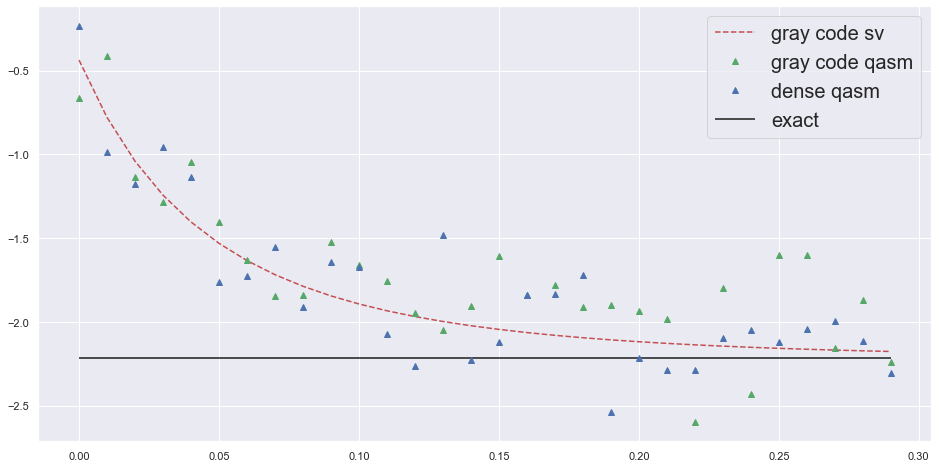

In [6]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="gray code sv")
plt.plot(time,qasm_energies_gc,'g^',label="gray code qasm")
plt.plot(time,qasm_energies_dense,'b^',label="dense qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [7]:
class JordanWignerHamiltonian(EncodingHamiltonian):
    def __init__(self, H, qiskit_order=True):    
        """ Class for the Jordan-Wigner encoded Hamiltonian. 

        Parameters: 
            H (np.matrix) : Hamiltonian matrix to be encoded 
            
            qiskit_order (bool): Determines whether to order the qubits in qiskit order, i.e.
                in "reverse" as compared to the typical ordering. 
        """
        super(JordanWignerHamiltonian, self).__init__(H, qiskit_order)

        self.N_qubits=self.N_states
#         self.pauli_rep = jordan_wigner(self.ferm_rep) # In terms of Paulis; for sparse Hamiltonian just JW
#         self.relabel_qubits() # 0 index the qubits to match dense representation
        self.pauli_rep = self._build_pauli_rep()
        self.pauli_coeffs = qubit_operator_to_dict(self)
        self.pauli_partitions = self._pauli_partitions()
        self.n_partitions = len(self.pauli_partitions.keys())
        
        self.matrix = self._to_matrix() # Numerical matrix

    def _build_pauli_rep(self):
        pauli_rep=jordan_wigner(self.ferm_rep).terms.items()
        # The Jordan-Wigner transform from OpenFermion gives us Paulis where 
        # the qubits are 1-indexed. Convert to 0 indexing, and if we are using
        # Qiskit order, we also have to reverse the order of the Paulis.
        new_pauli_rep = QubitOperator()

        for pauli, coeff in pauli_rep:
            operator_string = ""
            for qubit in pauli:
                operator_string += (qubit[1] + str(qubit[0] - 1) + " ")
            new_pauli_rep += coeff.real * QubitOperator(operator_string)

        return new_pauli_rep

    
    def _to_matrix(self):
        mat = np.zeros((self.N_states, self.N_states))

        # For each term in the Hamiltonian, populate the relevant entry in the matrix
        for ferm_op in self.ferm_rep:
            dag_op, op = list(ferm_op.terms.keys())[0]
            dag_idx, op_idx = dag_op[0]-1, op[0]-1
            mat[dag_idx, op_idx] = ferm_op.terms[(dag_op, op)]

        return mat

    def _pauli_partitions(self):
        """
        Partition pauli terms in Hamiltonian into commuting sets 
        """
        pauli_dict=self.pauli_coeffs
        commuting_sets=get_commuting_sets(list(pauli_dict.keys()))

        return commuting_sets

In [8]:
Nmax=4
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
H_sparse=SparseEncodingHamiltonian(N_states=len(H),qiskit_order=True)
H_jw=JordanWignerHamiltonian(H)
print(H_jw.matrix)
print(H_sparse.matrix)
eigsp,_= eigh(H_jw.matrix)
print("eigsp ",eigsp)
# print(H_jw.pauli_rep)
print(H_jw.pauli_coeffs)
print(H_sparse.pauli_coeffs)
print("")
print(H_jw.pauli_partitions)
print(H_sparse.pauli_partitions)

[[-0.43658111 -4.28660705  0.        ]
 [-4.28660705 12.25       -7.82623792]
 [ 0.         -7.82623792 19.25      ]]
[[-0.43658111 -4.28660705  0.        ]
 [-4.28660705 12.25       -7.82623792]
 [ 0.         -7.82623792 19.25      ]]
eigsp  [-2.0456709   8.56158173 24.54750806]
{'III': 15.531709445, 'IIZ': 0.21829055499999983, 'IXX': -2.1433035249352805, 'IYY': -2.1433035249352805, 'IZI': -6.125, 'XXI': -3.913118960624632, 'YYI': -3.913118960624632, 'ZII': -9.625}
{'IXX': -2.1433035249352805, 'XXI': -3.913118960624632, 'IYY': -2.1433035249352805, 'YYI': -3.913118960624632, 'III': 15.531709445, 'IIZ': 0.21829055499999983, 'IZI': -6.125, 'ZII': -9.625}

{'ZZZ': ['III', 'IIZ', 'IZI', 'ZII'], 'XXX': ['IXX', 'XXI'], 'YYY': ['IYY', 'YYI']}
{0: {'IXX': -2.1433035249352805, 'XXI': -3.913118960624632}, 1: {'IYY': -2.1433035249352805, 'YYI': -3.913118960624632}, 2: {'III': 15.531709445, 'IIZ': 0.21829055499999983, 'IZI': -6.125, 'ZII': -9.625}}


In [9]:
num_iterations=30
delta_time=0.01
n_qubits=H_sparse.N_qubits
print("num qubits :",n_qubits)
initialization="uniform"
backend = 'statevector_simulator'
sv_energies_jw,_=run_qite_experiment(H_jw,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)
print(sv_energies_jw)

  0%|          | 0/30 [00:00<?, ?it/s]

num qubits : 3


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]

[ 9.47528696  6.3970681   4.32732445  2.97780221  2.07886162  1.4465742
  0.97177514  0.59379754  0.27975579  0.01170782 -0.22052977 -0.42319289
 -0.60052213 -0.75573329 -0.89148463 -1.01009329 -1.11363101 -1.20396491
 -1.28277558 -1.35156735 -1.41167737 -1.46428573 -1.51042689 -1.55100229
 -1.58679335 -1.61847442 -1.64662534 -1.6717431  -1.69425262 -1.71451646]


In [10]:
sv_energies_sparse,_=run_qite_experiment(H_sparse,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)
print(sv_energies_sparse)

100%|██████████| 30/30 [00:22<00:00,  1.31it/s]

[ 9.47528696  6.3970681   4.32732445  2.97780221  2.07886162  1.4465742
  0.97177514  0.59379754  0.27975579  0.01170782 -0.22052977 -0.42319289
 -0.60052213 -0.75573329 -0.89148463 -1.01009329 -1.11363101 -1.20396491
 -1.28277558 -1.35156735 -1.41167737 -1.46428573 -1.51042689 -1.55100229
 -1.58679335 -1.61847442 -1.64662534 -1.6717431  -1.69425262 -1.71451646]


[-2.0456709   8.56158173 24.54750806]


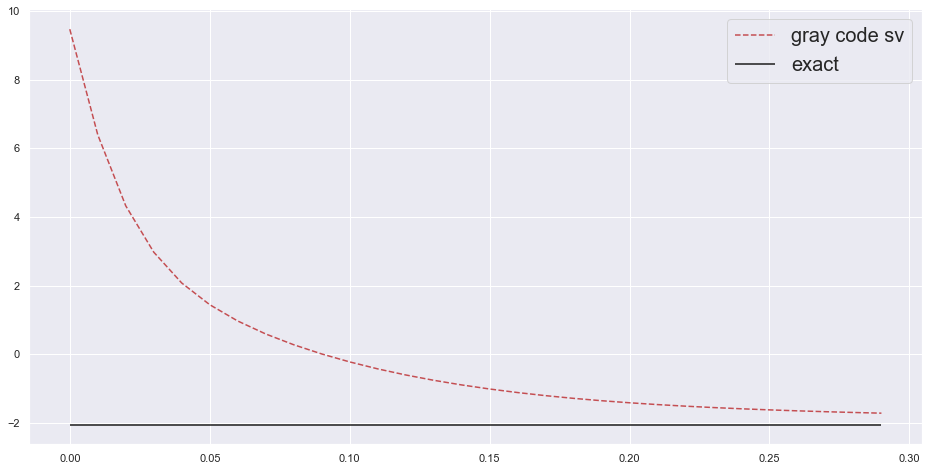

In [11]:
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies_jw,'r--',label="gray code sv")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [12]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
n_qubits=H_jw.N_qubits
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_jw,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_jw,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XXX ['III', 'IIX', 'IXI', 'IXX', 'XII', 'XIX', 'XXI', 'XXX']
XXY ['IIY', 'IXY', 'XIY', 'XXY']
XXZ ['IIZ', 'IXZ', 'XIZ', 'XXZ']
XYX ['IYI', 'IYX', 'XYI', 'XYX']
XYY ['IYY', 'XYY']
XYZ ['IYZ', 'XYZ']
XZX ['IZI', 'IZX', 'XZI', 'XZX']
XZY ['IZY', 'XZY']
XZZ ['IZZ', 'XZZ']
YXX ['YII', 'YIX', 'YXI', 'YXX']
YXY ['YIY', 'YXY']
YXZ ['YIZ', 'YXZ']
YYX ['YYI', 'YYX']
YYY ['YYY']
YYZ ['YYZ']
YZX ['YZI', 'YZX']
YZY ['YZY']
YZZ ['YZZ']
ZXX ['ZII', 'ZIX', 'ZXI', 'ZXX']
ZXY ['ZIY', 'ZXY']
ZXZ ['ZIZ', 'ZXZ']
ZYX ['ZYI', 'ZYX']
ZYY ['ZYY']
ZYZ ['ZYZ']
ZZX ['ZZI', 'ZZX']
ZZY ['ZZY']
ZZZ ['ZZZ']


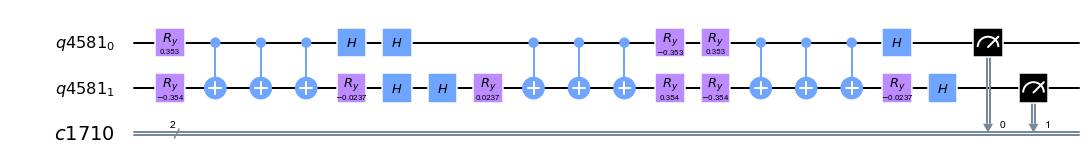

In [13]:
def add_cnot_gate(circuit,q,c,t,num_cnot_pairs=0):
    """
    Add (num_cnot_pairs+1) CNOT gates to ith and jth qubits [j=(i+1)%N_qubits] 
    to circuit and append the CNOT gates to operators
    
    Inputs:
        circuit (QuantumCircuit) : quantum circuit
        
        q (QuantumRegister) : quantum register for circuit
        
        c (int) : index of control qubit
        t (int) : index of target qubit 
        
        num_cnot_pairs (int,optional) : number of pairs of CNOT gates inserted as 
            "resolution of identity" with every CNOT gate in circuit.  
            Used for error extrapolation.
            
    Returns:
        circuit with CNOT gates appended
    """
    for n_pairs in range(num_cnot_pairs):
        circuit.cx(q[c], q[t])
        circuit.cx(q[c], q[t])

    circuit.cx(q[c], q[t])
    
    return circuit

def fold_circuit(circuit,num_folding):
    """
    Applies and then inverts circuit num_folding times before finally running the circuit
    Used for error extrapolation? 
    
    Input:
        circuit (QuantumCircuit) : quantum circuit 
        
        num_folding (int) : Number of times circuit is "folded"
        
    Returns:
        circuit (QuantumCircuit) : folded circuit
    
    """
    folded_circuit=circuit
    for n in range(num_folding):
        folded_circuit=folded_circuit.combine(circuit.inverse())
        folded_circuit=folded_circuit.combine(circuit)
    return folded_circuit


def append_Gray_code_variational_ansatz(circuit,q,thetas,num_cnot_pairs=0):
    """ 
    Creates a variational ansatz for the Gray code encoding.

    These circuits have a more familiar 'variational form'. Since in the dense case we
    are using all elements in the space, we can use something a bit more general. These
    circuits are layers of Y rotations followed by entangling gates on all the qubits.

    Parameters:
        circuit (QuantumCircuit) : quantum circuit
        
        q (QuantumRegister) : quantum register for circuit
        
        thetas (np.array) : Angles parameterizing ansatz wavefunction.  Number of
            angles is one fewer than the number of states.
        
        num_cnot_pairs (int,optional) : number of pairs of CNOT gates inserted as 
            "resolution of identity" with every CNOT gate in circuit.  
            Used for error extrapolation.
            
    Returns:
        circuit (QuantumCircuit) : circuit with variational ansatz added

    """
    N_qubits = q.size

    num_remaining_thetas = len(thetas)
    qubit_idx = 0
    last_layer = False

    while num_remaining_thetas > 0:
        # If it's the last layer, only do as many CNOTs as we need to
        if last_layer:
            for i in range(num_remaining_thetas):
                t=(i+1)%N_qubits ## target
                circuit=add_cnot_gate(circuit,q,i,t,num_cnot_pairs)
         
            for qubit in range(1, num_remaining_thetas+1):
                circuit.ry(thetas[num_remaining_thetas - 1], q[qubit%N_qubits])
                num_remaining_thetas -= 1
            break
        # If it's not the last layer, apply rotations and then increment counters
        else:
            circuit.ry(thetas[num_remaining_thetas - 1], q[qubit_idx])
            qubit_idx += 1
            num_remaining_thetas -= 1

            if N_qubits >= 2:
                # If we have a full layer of parameters ahead, do the full CNOT cycle
                if qubit_idx == N_qubits and num_remaining_thetas > N_qubits:
                    for i in range(N_qubits):
                        t=(i+1)%N_qubits ## target
                        operations=add_cnot_gate(circuit,q,i,t,num_cnot_pairs)
                    ##Reset qubit_idx to zero.  
                    qubit_idx = 0
                
                # Otherwise, we are entering the last layer
                elif qubit_idx == N_qubits and num_remaining_thetas <= N_qubits:
                    last_layer = True
                
    return circuit

def append_Jordan_Wigner_variational_ansatz(circuit, q, thetas, num_cnot_pairs=0):
    """ Creates a variational ansatz for the Jordan-Wigner encoding.

    These circuits were defined in arXiv:1904.04338, and produce an ansatz state
    over the occupation subset of the computational basis (|1000>, |0100>, etc.)
    with generalized spherical coordinates as their amplitudes.

    The version here is the same circuit, but with the qubit order inverted.
    This was found to lead to greater stability in the SPSA optimization procedure
    due to the relationships between of the variational parameters and the
    "strength" of the basis states in the Hamiltonian.

    Parameters:
        thetas (np.array) : Angles parameterizing ansatz wavefunction.  Number of
            angles is one fewer than the number of qubits in the circuit.

    Returns:
        circuit (QuantumCircuit) : quantum circuit

    """
    # The number of parameters tells us the number of states 
    # which is the same as the the number of qubits 
    N_states = len(thetas) + 1
    N_qubits = N_states
 
    circuit.x(q[N_qubits-1])
    circuit.ry(thetas[0], q[N_qubits-2])

    # Insert CNOT gates
    control_idx,target_idx=N_qubits-2,N_qubits-1
    circuit=add_cnot_gate(circuit,q,control_idx,target_idx,num_cnot_pairs)

    # Recursive cascade
    for control_idx in range(N_qubits - 2, 0, -1):
        target_idx = control_idx - 1

        circuit.ry(thetas[control_idx]/2, q[target_idx])        
        circuit=add_cnot_gate(circuit,q,control_idx,target_idx,num_cnot_pairs)        
        circuit.ry(-thetas[control_idx]/2, q[target_idx])
        circuit=add_cnot_gate(circuit,q,control_idx,target_idx,num_cnot_pairs)
        circuit=add_cnot_gate(circuit,q,target_idx,control_idx,num_cnot_pairs)
    
    return circuit


def append_measurement_basis_rotation(circuit,q,measurement_id):
    """
    Append gates to transform qubit states to measurement basis 
    
    input:
        circuit (QuantumCircuit) : quantum circuit 

        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        
        measurement_id (str) : pauli operator to be measured
    
    returns:
        circuit (QuantumCircuit) : circuit now transformed to 
                measurement basis defined by measurement_id
    """
    ## Reverse order to gates are applied right to left Maybe??
    measurement_id_revered=measurement_id[::-1]

    for qubit_idx in range(len(measurement_id)):
#         print(f"qubit {qubit_idx} of {measurement_id}")
        pauli=measurement_id_revered[qubit_idx]
        if pauli == 'X':
            circuit.h(q[qubit_idx])
        elif pauli == 'Y':
            circuit.sdg(q[qubit_idx])
            circuit.h(q[qubit_idx])

    return circuit


def variational_circuit(encoding,thetas,measurement_idx,backend_name,num_cnot_pairs=0,num_folding=0):
    """
    Construct variational circuit for Gray code endcoding 
    """
    N_states=len(thetas)+1
    if encoding=="Graycode":
        N_qubits = int(np.ceil(np.log2(N_states)))
    elif encoding == "JordanWigner":
        N_qubits=N_states
    else:
        raise ValueError("Invalid encoding for variational circuit.")
        
    q, c = QuantumRegister(N_qubits), ClassicalRegister(N_qubits)
    circuit = QuantumCircuit(q, c)
    
    if encoding=="Graycode":
        circuit=append_Gray_code_variational_ansatz(circuit,q,thetas,num_cnot_pairs)
    else: # must be "JordanWigner" else exception raised earlier 
        circuit=append_Jordan_Wigner_variational_ansatz(circuit,q,thetas,num_cnot_pairs)
        
    if backend_name=="qasm_simulator":
#         print(f"m idx: {measurement_idx}")
        circuit=append_measurement_basis_rotation(circuit,q,measurement_idx)
    circuit=fold_circuit(circuit,num_folding=num_folding)
    if backend_name=="qasm_simulator":
        circuit.measure(q,c)
    
    return circuit

## Testing
N_states=4
encoding="Graycode"
N_qubits = int(np.ceil(np.log2(N_states)))

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,num_folding=1)
circuit.draw(output="mpl",filename="circuit.pdf")


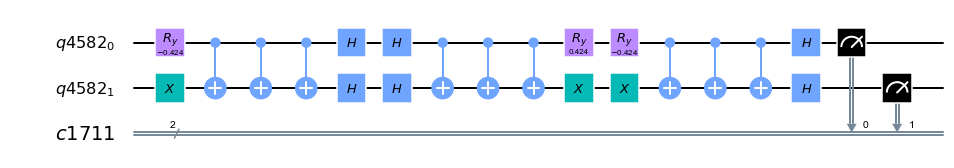

In [14]:
## Testing
N_states=2
encoding="JordanWigner"
N_qubits = N_states

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,num_folding=1)
circuit.draw(output="mpl",filename="circuit.pdf")


In [15]:
###############################################################################################
def compute_energy_extrap(theta, backend, hamiltonian, device, noise_model, shots, num_cnot_pairs, num_folding):
    """
    Not sure what this does...
    """
    energies = []
    noise_parameters = []
    CNOTs = False
    Folding = False
    if( num_cnot_pairs > 0 ): CNOTs=True
    if( num_folding > 0 ): Folding=True
    if( CNOTs ): iter_max = num_cnot_pairs + 1
    if( Folding ): iter_max = num_folding + 1
    energies = []
    noise_parameters = []

    if type(hamiltonian) == JordanWignerHamiltonian:
        encoding="JordanWigner"
    elif type(hamiltonian) == GrayCodeHamiltonian:
        encoding="Graycode"
    else:
        raise ValueError("Invalid encoding for variational circuit.")
    
    for num in range(iter_max+1):
        complete_exp_vals = {}
        for measurement_idx in hamiltonian.pauli_partitions.keys():
            # Create the circuit depending on the Hamiltonian and measurement
            circuit = None
            
            if(CNOTs): variational_circuit(encoding,thetas,measurment_idx,backend.name(),num,0)
            if(Folding): variational_circuit(encoding,thetas,measurment_idx,backend.name(),0,num)

            # Execute the circuit (on device if specified) and get the result
            # For QASM simulator, run the circuit for as many shots as desired.
            if( noise_model != None ):
                job = execute(circuit,
                        backend=backend,
                        shots = shots,
                        noise_model = noise_model,
                        basis_gates = noise_model.basis_gates,
                        optimization_level=0)
            elif device != None:
                job = execute(circuit,
                        backend=backend,
                        shots = shots,
                        coupling_map = device.coupling_map,
                        noise_model = device.noise_model,
                        basis_gates = device.noise_model.basis_gates,
                        initial_layout = device.layout,
                        optimization_level=0)
            else:
                job = execute(circuit, backend, shots=shots, optimization_level=0)

            result = job.result().get_counts(circuit)

            # Perform measurement error mitigation if specified
            if device != None:
                if device.meas_filter:
                    result = device.meas_filter.apply(result)

            # Get the expectation value of each Pauli from the results
            for pauli in hamiltonian.pauli_partitions[measurement_idx].keys():
                complete_exp_vals[pauli] = pauli_expectation_value(pauli, result)
        en = 0.0
        for pauli, coeff in hamiltonian.pauli_coeffs.items():
            en += coeff * complete_exp_vals[pauli]
        energies.append(en)
        noise_parameters.append( 2*num+1 )
    coef = np.polyfit(noise_parameters,energies,1)
    linear_fit = np.poly1d(coef)
    #print( "zero-noise extrapolation: n=0:{:8.4f}, n=1:{:8.4f}, n=3:{:8.4f}, n=5:{:8.4f}".format(linear_fit(0), linear_fit(1), linear_fit(3), linear_fit(5)) )
    return linear_fit(0)

In [22]:
def compute_energy(theta, backend, hamiltonian, device=None, noise_model=None, shots=10000, num_cnot_pairs=0, num_folding=0, zero_noise_extrapolation=False):
    """
    Computes the expectation value of the hamiltonian by running a quantum circuit for
    wavefunction parameterized by theta.

    Parameters
        theta (np.array) : Initial guesses for the ground state wavefunction parameterization.

        backend (BaseBackend): Qiskit backend to execute circuits on.

        hamiltonian : Deuteron Hamiltonian. See src/hamiltonian.py for class definitions.

        device (Device, optional) : Simulations of IBMQ devices.  If device=None, qiskit QASM simulator
            applied without any noise model. Default: None.

        shots (int, optional): Number of repetitions of each circuit, for sampling. Default: 10000.


    """
    if( zero_noise_extrapolation and backend.name() == 'qasm_simulator' ):
        return compute_energy_extrap( theta, backend, hamiltonian, device, noise_model, shots, num_cnot_pairs, num_folding )
    # Cumulative energy
    energy = 0
    # Store the expectation values of all the operators
    complete_exp_vals = {}

    if type(hamiltonian) == JordanWignerHamiltonian:
        encoding="JordanWigner"
    elif type(hamiltonian) == GrayCodeHamiltonian:
        encoding="Graycode"
    else:
        raise ValueError("Invalid encoding for variational circuit.")

#     print(hamiltonian.pauli_partitions.keys())    
    for measurement_idx in hamiltonian.pauli_partitions.keys():

        # Create the circuit depending on the Hamiltonian and measurement
        circuit = variational_circuit(encoding,theta,measurement_idx,backend.name(),num_cnot_pairs,num_folding)

        # Execute the circuit (on device if specified) and get the result
        # For QASM simulator, run the circuit for as many shots as desired.
#         print(measurement_idx)
#         print(circuit.draw())

        if backend.name() == 'qasm_simulator':
            if( noise_model != None ):
                job = execute(circuit,
                        backend=backend,
                        shots = shots,
                        noise_model = noise_model,
                        basis_gates = noise_model.basis_gates,
                        optimization_level=0)
            elif device is not None:
                job = execute(circuit,
                        backend=backend,
                        shots = shots,
                        coupling_map = device.coupling_map,
                        noise_model = device.noise_model,
                        basis_gates = device.noise_model.basis_gates,
                        initial_layout = device.layout,
                        optimization_level=0)
            else:
                job = execute(circuit, backend, shots=shots, optimization_level=0)

            result = job.result().get_counts(circuit)

            # Perform measurement error mitigation if specified
            if device is not None:
                if device.meas_filter:
                    result = device.meas_filter.apply(result)

            # Get the expectation value of each Pauli from the results
            for pauli in hamiltonian.pauli_partitions[measurement_idx]:
                complete_exp_vals[pauli] = pauli_expectation_value(pauli, result)

        # For statevector simulator, compute the explicit wavefunction at the end
        # and calculate the expectation values using the trace.
        elif backend.name() == 'statevector_simulator':
            result = execute(circuit, backend, shots=1).result()
            psi = result.get_statevector(circuit)
#             rho = np.einsum("i,j->ij", psi, np.conj(psi))

            # Paulis in the Hamiltonian are already in Qiskit ordering, which is the
            # same ordering as the psi that will come out.
            for pauli in hamiltonian.pauli_partitions[measurement_idx]:
                pauli_mat = get_pauli_matrix(pauli)
                complete_exp_vals[pauli]=e_value=np.conj(psi).T @ pauli_mat @ psi
#                 complete_exp_vals[pauli] = np.real(np.trace(np.dot(rho, pauli_mat)))

    # Now that we have the complete set of expectation values, we can compute the energy
    for pauli, coeff in hamiltonian.pauli_coeffs.items():
        energy += coeff * complete_exp_vals[pauli]

    return energy.real


In [23]:
backend=Aer.get_backend("statevector_simulator")
hw=1.0 ## Set internally by toy hamilonian
J=1
Nmax=2
# encoding="Graycode"
encoding="JordanWigner"
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 

if encoding=="Graycode":
    H_qubit=GrayCodeHamiltonian(H)
else:
    H_qubit=JordanWignerHamiltonian(H)
# print(H_graycode.pauli_partitions.keys())
N_states = H_qubit.N_states
N_qubits = H_qubit.N_qubits 

# thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)
print(N_states)
thetas=[1.0]

energy=compute_energy(thetas, backend, H_qubit)


print(H_qubit.pauli_rep)
# print(H_qubit.pauli_partitions)
print("")
print(energy)

2
5.906709445000001 [] +
-2.1433035249352805 [X0 X1] +
-2.1433035249352805 [Y0 Y1] +
0.21829055499999983 [Z0] +
-6.125 [Z1]

5.72694850291904


In [24]:
# For various optimizers
from noisyopt import minimizeSPSA
from scipy.optimize import minimize
from iminuit import minimize as iminimize

def do_experiment(theta,hamiltonian,parameters):
    """
    Use variational quantum eigensovler (VQE) to obtain ground state energy of the Hamiltonian.
    Energies at each step evaluated by running a quatnum circuit.

    Parameters
        theta (np.array) : Initial guesses for the ground state wavefunction theta parameters.

        hamiltonian : Deuteron Hamiltonian. See src/hamiltonian.py for class definitions.

        parameters (dictionary) : Input parameters for VQE.

    Returns
        res (scipy.optimize.OptimizeResult) : Results of VQE

    """
    # Set up backend
    backend = Aer.get_backend(parameters['backend'])
    device = None
    noise_model = None
    if parameters['device_name'] is not None:
        if ( parameters['device_name'][0:6] == "custom" ):
            noise_model = noise.NoiseModel()
            errors = parameters['device_name'].split("_")
            error1 = float(errors[1])
            error2 = float(errors[2])
            error_1 = noise.errors.depolarizing_error(error1, 1)
            error_2 = noise.errors.depolarizing_error(error2, 2)
            noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
            noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        else:
            if parameters['mitigate_meas_error']:
                device = Device(parameters['device_name'], True, hamiltonian.N_qubits, layout=parameters['layout'])
            else:
                device = Device(parameters['device_name'], False, hamiltonian.N_qubits, layout=parameters['layout'])

    if device is not None:
        print("Device specifications")
        pprint(vars(device))

    number_cnot_pairs = 0
    if( "number_cnot_pairs" in parameters ): number_cnot_pairs = parameters['number_cnot_pairs']
    number_circuit_folding = 0
    if( "number_circuit_folding" in parameters ): number_cnot_pairs = parameters['number_circuit_folding']
    zero_noise_extrapolation=False
    if( "zero_noise_extrapolation" in parameters): zero_noise_extrapolation = parameters['zero_noise_extrapolation']

    # Run the minimization routine
    if parameters['optimizer'] != 'SPSA':
        if parameters['optimizer'] == 'MIGRAD': # iminuit option
            res = iminimize(compute_energy, theta,
                    args=(backend, hamiltonian,
                        device,
                        noise_model,
                        parameters['N_shots'],
                        number_cnot_pairs,
                        number_circuit_folding,
                        zero_noise_extrapolation),
                    method=parameters['optimizer'], options={'maxfev':parameters['N_iter']})
            # Display diagnostic information:
            # res = iminimize(compute_energy, theta, args=(backend, hamiltonian, device), method=parameters['optimizer'], options={'maxfev':parameters['N_iter'],'disp':True})
        else:
            # "Regular" scipy optimizers

            res = minimize(compute_energy, theta,
                    args=(backend, hamiltonian,
                        device,
                        noise_model,
                        parameters['N_shots'],
                        number_cnot_pairs,
                        number_circuit_folding,
                        zero_noise_extrapolation),
                    method=parameters['optimizer'], options={'maxiter':parameters['N_iter']})
    else:
        res = minimizeSPSA(compute_energy,
                x0=theta,
                args=(backend, hamiltonian,
                    device,
                    noise_model,
                    parameters['N_shots'],
                    number_cnot_pairs,
                    number_circuit_folding,
                    zero_noise_extrapolation),
                niter=parameters['N_iter'],
                paired=False,
                a=parameters['spsa_a'],
                c=parameters['spsa_c'],
        )

    return res

In [34]:

hw=1.0 ## Set internally by toy hamilonian
J=1
Nmax=4
# encoding="Graycode"
encoding="JordanWigner"
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 

if encoding=="Graycode":
    H_qubit=GrayCodeHamiltonian(H)
else:
    H_qubit=JordanWignerHamiltonian(H)

print(H_qubit.pauli_rep)
N_states = H_qubit.N_states
print(N_states)
N_qubits = H_qubit.N_qubits 
# thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)
# thetas=[1.0]
N_trials=10
thetas=[[1.0]*(N_states-1)]*N_trials

parameters = {
# "encoding": 'gray_code',
"encoding": 'jordan_wigner',
"N_states": 3,
# "backend": 'statevector_simulator',
"backend": 'qasm_simulator',
"N_shots": 10000,
"N_cpus": 1,
"spsa_a": 0.628,
"spsa_c": 0.1,
"N_iter": 1000,
"optimizer": 'SPSA',
"N_trials": N_trials,
"device_name": None,
"mitigate_meas_error": False,
"output_dir": 'outputs-qiskit-statevector_simulator'
}
# print(H_qubit.pauli_partitions)
energies=[]
for theta in thetas:
    res=do_experiment(theta,H_qubit,parameters)
    energies.append(res["fun"])
print(energies)

15.531709445 [] +
-2.1433035249352805 [X0 X1] +
-2.1433035249352805 [Y0 Y1] +
0.21829055499999983 [Z0] +
-3.913118960624632 [X1 X2] +
-3.913118960624632 [Y1 Y2] +
-6.125 [Z1] +
-9.625 [Z2]
3
[-2.064736451436139, -2.158329972514669, -1.9088576916943643, -2.0057129211058413, -2.046352111241367, -1.8909700876396842, -2.0501178856608178, -2.0001994349356638, -2.0196000575204627, -2.016119990009061]


In [30]:
thetas=[[1.0]*3]*4
print(thetas)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
